In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# 0. Pytorch GPU 환경 구축

[참고1] https://pytorch.org/get-started/locally/  
[참고2] https://lsjsj92.tistory.com/494  
[참고3] PyTorch를 활용한 강화학습/심층강화학습 실전 입문 (218p ~ 219p)

In [2]:
conda install pytorch torchvision cudatoolkit=10.0 -c pytorch

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
print(torch.__version__)

1.2.0


In [4]:
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

In [5]:
torch.cuda.is_available()

True

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# 사용방법: 명령어.to(device) → GPU환경, CPU환경에 맞춰서 동작

cuda


# 1. MNIST train, test dataset 가져오기

In [7]:
# "": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform = transforms.ToTensor(), # train 용으로 쓰겠다.
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform = transforms.ToTensor(), # test 용으로 쓰겠다.
                      target_transform=None, download=True)

9920512it [00:02, 4834960.75it/s]                                                                                      


Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw


32768it [00:00, 51904.30it/s]                                                                                          


Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw


1654784it [00:00, 1849661.78it/s]                                                                                      


Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw


8192it [00:00, 17411.97it/s]                                                                                           


Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
Processing...
Done!


# 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


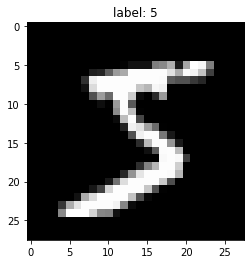

In [8]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태:", image.size())
print("label: ", label)

# 그리기
img = image.numpy() # image 타입을 numpy로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 3. 데이터 로드함수

학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [9]:
# hyper parameters
batch_size = 1024 # 배치사이즈 단위로 weight 갱신
learning_rate = 0.01
num_epoch = 400 # 전체 6만장의 데이터를 400번 반복해서 학습시킬 것이다.

In [10]:
train_loader = torch.utils.data.DataLoader(mnist_train, # mnist_train을 학습 시키자.
                                           batch_size=batch_size, # batch_size 만큼 나누자
                                           shuffle=True, num_workers=2, # 나머지는 버려라
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                           batch_size=batch_size,
                                           shuffle=False, num_workers=2,
                                           drop_last=True)

## 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


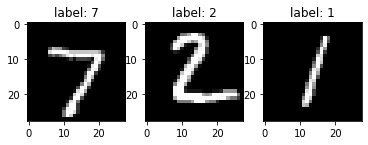

[1]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


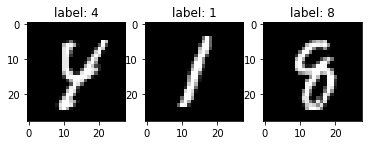

[2]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


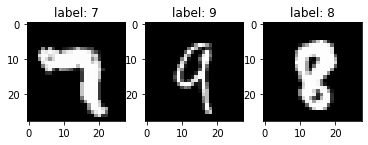

[3]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


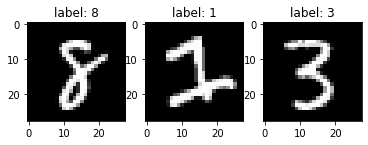

[4]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


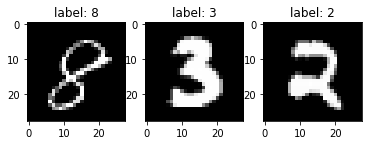

[5]
한 번에 로드되는 데이터 크기: 1024
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)
(1, 28, 28)
(28, 28)


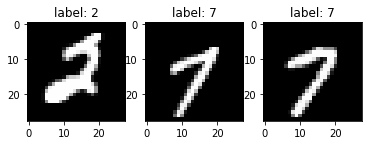

In [11]:
n = 3 # 샘플로 그려볼 데이터 갯수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>5:
        break
    
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy() # image 타입을 numpy로 변환 (1, 28, 28)
        print(img.shape)
        img = img.reshape((img.shape[1], img.shape[2])) # (1, 28, 28) → (28, 28)
        print(img.shape)
        
        plt.subplot(1, n, j+1) # (1, 3) 형태 plot의 j번째 자리에 그리겠다.
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 4. 모델 선언

In [12]:
# 모델 선언
# * 퍼셉트론(2 hidden layer) *
model = nn.Sequential(
    nn.Linear(28*28, 256), # fully connected
    nn.Sigmoid(),
    nn.Linear(256, 128),
    nn.Linear(128, 10)
)

In [13]:
print(list(model.parameters())) # 초기 파라미터 출력

[Parameter containing:
tensor([[ 0.0064, -0.0228,  0.0012,  ...,  0.0266, -0.0299, -0.0049],
        [ 0.0265,  0.0181,  0.0180,  ..., -0.0117, -0.0151,  0.0031],
        [-0.0144,  0.0180,  0.0177,  ...,  0.0245, -0.0147, -0.0321],
        ...,
        [ 0.0270,  0.0151,  0.0254,  ...,  0.0283,  0.0310, -0.0133],
        [ 0.0201,  0.0215, -0.0331,  ..., -0.0098,  0.0241,  0.0082],
        [-0.0292, -0.0261,  0.0183,  ...,  0.0006, -0.0105, -0.0046]],
       requires_grad=True), Parameter containing:
tensor([ 2.8988e-02, -3.0944e-02,  1.1662e-02,  1.5532e-02, -6.9045e-03,
         2.8333e-02,  2.8179e-02, -1.9827e-02,  2.9573e-02,  4.3718e-03,
        -3.2806e-02, -2.9916e-02, -3.4442e-03,  1.5089e-02, -2.8516e-03,
         1.1751e-02,  1.7895e-03,  3.3497e-02,  1.0319e-02, -2.7984e-02,
        -4.7268e-03, -6.7959e-03, -1.5171e-02, -3.4933e-02, -2.8886e-02,
        -2.2519e-02,  4.9295e-03,  2.7085e-02,  2.4411e-03,  2.0822e-02,
         8.9216e-03, -2.4335e-04,  8.2041e-03, -9.0764e

In [14]:
model = model.to(device)
# model = model.cuda() # GPU 가속 사용

In [15]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = imgs # x
        label = Variable(labels).to(device) # y
        # 파이토치에서 모델에다가 어떤 데이터를 넣을때, Variable이라는 키워드로 씌워줘야 한다. (Pytorch 문법)
        # .cuda() GPU에 로드되기 위함. 만약 CPU로 설정되어 있다면 에러남
        
        # (batch_size, 1, 28, 28) → (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        # (batch_size, 28, 28) → (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad = False).to(device) # .cuda() # back propagation 사용여부
        
        output = imodel(img) # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0) # batch_size씩 더함
        correct += (output_index == label).sum().float() # y_hat ↔ y
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [16]:
ComputeAccr(test_loader, model) # 학습을 시키지 않은 상태

Accuracy of Test Data: 9.733073234558105


# 5. loss, optimizer

In [17]:
loss_func = nn.CrossEntropyLoss() # 분류 → 크로스엔트로피 → logit(# of classes), target(1) 
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # 최적화 방법: Stochastic Gradient Descent

# 6. 학습

In [18]:
import time
start_total = time.time()
start = time.time()

for i in range(num_epoch): 
    for j, [imgs, labels] in enumerate(train_loader): # batch_size 만큼
        
        img = imgs # (batch_size, 1, 28, 28)
        label = Variable(labels).to(device) # .cuda() # (batch_size)
        
        # (batch_size, 1, 28, 28) → (batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        # (batch_size, 28, 28) → (batch_size, 28*28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img = Variable(img, requires_grad = True).to(device) # .cuda() # back propagation 사용여부
        
        optimizer.zero_grad()
        output = model(img) # forward prop.
        loss = loss_func(output, label) # logit(# of classes), target(1)
        # img,output,label → (batch_size, 28*28), (batch_size, # of classes), (batch_size, 1)

        loss.backward() # back prop. - Gradient를 계산해서 각 노드에 저장
        optimizer.step() # weight 조정 - 저장된 Gradient를 이용해서 weight를 업데이트
        
    if i%10==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)        
        print(loss)
        
        end = time.time()
        print("Running Time: %f s\n" %(end - start))
        start = time.time()

end_total = time.time()
print("\nTotal Running Time: %f s" %(end_total - start_total))

0..
Accuracy of Test Data: 11.61024284362793
tensor(2.2967, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 4.813137 s

10..
Accuracy of Test Data: 40.36458206176758
tensor(2.2088, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 33.429637 s

20..
Accuracy of Test Data: 56.86848831176758
tensor(1.9133, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 32.465227 s

30..
Accuracy of Test Data: 67.81684112548828
tensor(1.2999, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 32.208900 s

40..
Accuracy of Test Data: 75.54253387451172
tensor(0.9195, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 32.238832 s

50..
Accuracy of Test Data: 80.44705200195312
tensor(0.7442, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 32.057334 s

60..
Accuracy of Test Data: 83.47439575195312
tensor(0.6179, device='cuda:0', grad_fn=<NllLossBackward>)
Running Time: 32.172010 s

70..
Accuracy of Test Data: 84.95008850097656
tensor(0.5162, device='cuda:0', 

# 7. 테스트

In [19]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 92.05728912353516


# 8. 학습된 파라미터 저장

In [20]:
netname = './nets/mlp_weight.pkl'
torch.save(model, netname, )

# model = torch.load(netname) # 이어서 학습하기

# 9. 실습1에 쓰인 .npz를 만드려면?

In [21]:
print(list(model.parameters())) # 초기 파라미터 출력

[Parameter containing:
tensor([[ 0.0064, -0.0228,  0.0012,  ...,  0.0266, -0.0299, -0.0049],
        [ 0.0265,  0.0181,  0.0180,  ..., -0.0117, -0.0151,  0.0031],
        [-0.0144,  0.0180,  0.0177,  ...,  0.0245, -0.0147, -0.0321],
        ...,
        [ 0.0270,  0.0151,  0.0254,  ...,  0.0283,  0.0310, -0.0133],
        [ 0.0201,  0.0215, -0.0331,  ..., -0.0098,  0.0241,  0.0082],
        [-0.0292, -0.0261,  0.0183,  ...,  0.0006, -0.0105, -0.0046]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0280, -0.0359,  0.0148,  0.0179, -0.0227,  0.0265,  0.0263, -0.0124,
         0.0308, -0.0051, -0.0280, -0.0409, -0.0061,  0.0163, -0.0047,  0.0128,
        -0.0012,  0.0405,  0.0041, -0.0297,  0.0041,  0.0090, -0.0258, -0.0253,
        -0.0205, -0.0332, -0.0124,  0.0266,  0.0130,  0.0260,  0.0014,  0.0080,
         0.0075,  0.0027,  0.0055,  0.0356,  0.0006,  0.0349,  0.0050,  0.0192,
        -0.0122, -0.0034,  0.0361,  0.0310,  0.0346,  0.0039,  0.0255, -0.00

In [22]:
param_list = list(model.parameters())

W1 = param_list[0].cpu().detach().numpy() # (256, 784)
b1 = param_list[1].cpu().detach().numpy() # (256)

W2 = param_list[2].cpu().detach().numpy() # (128, 256)
b2 = param_list[3].cpu().detach().numpy() # (128)

W3 = param_list[4].cpu().detach().numpy() # (10, 128)
b3 = param_list[5].cpu().detach().numpy() # (10)

print(W1.shape, b1.shape)
print(W2.shape, b2.shape)
print(W3.shape, b3.shape)

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)


In [23]:
np.savez_compressed('./nets/mlp_weight.npz',
                   W1=W1, b1=b1,
                   W2=W2, b2=b2,
                   W3=W3, b3=b3)

In [24]:
# 불러오는 테스트
weights = np.load('./nets/mlp_weight.npz')

W1 = weights['W1']
b1 = weights['b1']
W2 = weights['W2']
b2 = weights['b2']
W3 = weights['W3']
b3 = weights['b3']

print(W1.shape, b1.shape)
print(W2.shape, b2.shape)
print(W3.shape, b3.shape)

(256, 784) (256,)
(128, 256) (128,)
(10, 128) (10,)
